## Aprendizaje Supervisado

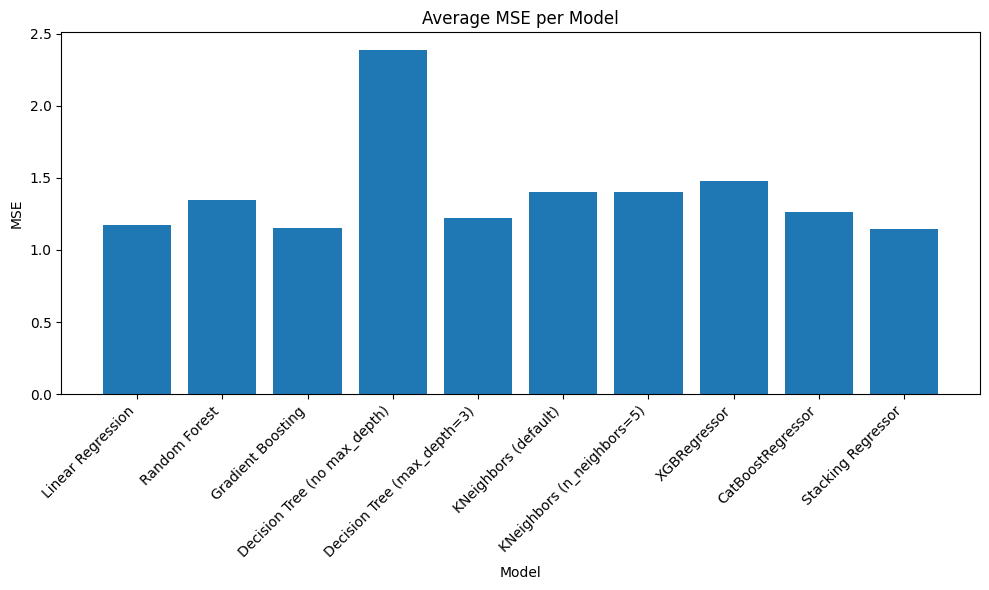

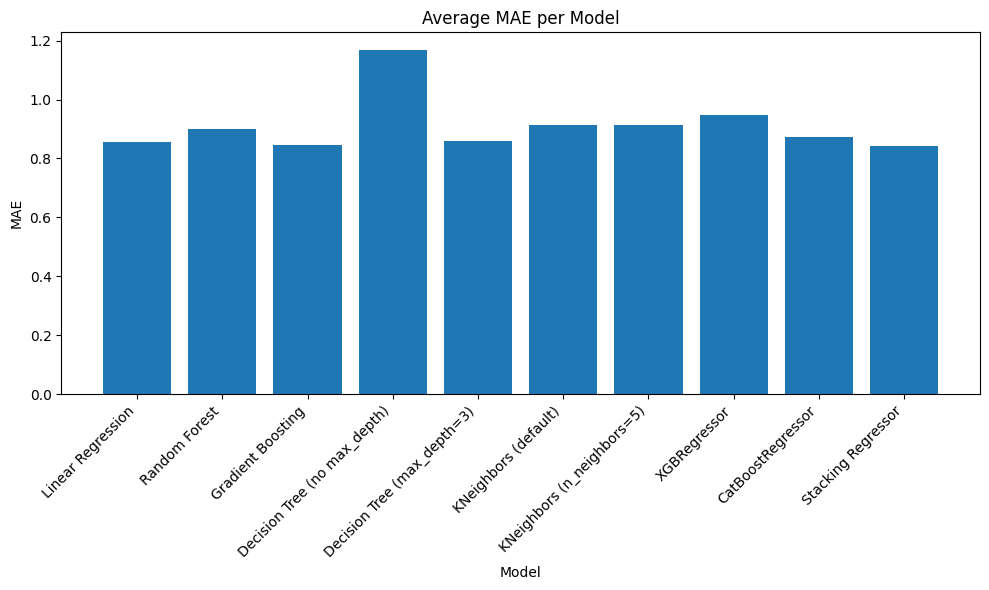

In [2]:
# Refactored code with separate model functions and visualizations for MSE and MAE per model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
!pip3 install catboost
from catboost import CatBoostRegressor
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the data
def preprocess_data():
    # matches = pd.read_csv("PremierLeague.csv")
    # List of URLs of the datasets
    urls = [
        "https://www.football-data.co.uk/mmz4281/2425/E0.csv",
        "https://www.football-data.co.uk/mmz4281/2324/E0.csv",
        "https://www.football-data.co.uk/mmz4281/2223/E0.csv",
        "https://www.football-data.co.uk/mmz4281/2122/E0.csv",
        "https://www.football-data.co.uk/mmz4281/2021/E0.csv",
        "https://www.football-data.co.uk/mmz4281/1920/E0.csv"
    ]

    # Load and preprocess the dataset
    dfs = [pd.read_csv(url) for url in urls]

    # Unir todos los DataFrames en uno solo
    matches = pd.concat(dfs, ignore_index=True)

    matches["goal_difference"] = matches["FTHG"] - matches["FTAG"]
    matches["HF"] = matches.groupby("HomeTeam")["goal_difference"].rolling(5).mean().reset_index(level=0, drop=True)
    matches["AW"] = matches.groupby("AwayTeam")["goal_difference"].rolling(5).mean().reset_index(level=0, drop=True)

    features = ["FTHG", "FTAG", "HS", "AS", "HST", "AST", "HC", "AC", "HY", "AY", "HR", "AR", "HF", "AW", "HomeTeam", "AwayTeam"]
    X = matches[features].fillna(0)
    y_home = matches["FTHG"]
    y_away = matches["FTAG"]

    return train_test_split(X, y_home, test_size=0.2, random_state=42), train_test_split(X, y_away, test_size=0.2, random_state=42)

# Function to create preprocessing pipeline
def create_pipeline(model):
    numeric_features = ["HF", "AW"]
    categorical_features = ["HomeTeam", "AwayTeam"]

    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    return Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Function to evaluate models
def evaluate_models(X_train, X_test, y_home_train, y_home_test, y_away_train, y_away_test):
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "Decision Tree (no max_depth)": DecisionTreeRegressor(random_state=42),
        "Decision Tree (max_depth=3)": DecisionTreeRegressor(max_depth=3, random_state=42),
        "KNeighbors (default)": KNeighborsRegressor(),
        "KNeighbors (n_neighbors=5)": KNeighborsRegressor(n_neighbors=5),
        "XGBRegressor": XGBRegressor(random_state=42, verbosity=0),
        "CatBoostRegressor": CatBoostRegressor(random_state=42, silent=True),
    }

    # Add StackingRegressor
    estimators = [
        ("lr", LinearRegression()),
        ("rf", RandomForestRegressor(n_estimators=100, random_state=42)),
        ("gb", GradientBoostingRegressor(random_state=42)),
    ]
    models["Stacking Regressor"] = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

    results = []

    for model_name, model in models.items():
        pipeline = create_pipeline(model)

        # Train and evaluate for home goals
        pipeline.fit(X_train, y_home_train)
        y_home_pred = pipeline.predict(X_test)
        home_mse = mean_squared_error(y_home_test, y_home_pred)
        home_mae = mean_absolute_error(y_home_test, y_home_pred)

        # Train and evaluate for away goals
        pipeline.fit(X_train, y_away_train)
        y_away_pred = pipeline.predict(X_test)
        away_mse = mean_squared_error(y_away_test, y_away_pred)
        away_mae = mean_absolute_error(y_away_test, y_away_pred)

        # Average metrics
        avg_mse = (home_mse + away_mse) / 2
        avg_mae = (home_mae + away_mae) / 2

        results.append({
            "Model": model_name,
            "Home MSE": home_mse,
            "Away MSE": away_mse,
            "Average MSE": avg_mse,
            "Home MAE": home_mae,
            "Away MAE": away_mae,
            "Average MAE": avg_mae
        })

    return pd.DataFrame(results)

# Function to plot results
def plot_results(results, metric):
    plt.figure(figsize=(10, 6))
    models = results["Model"]
    values = results[f"Average {metric}"]
    plt.bar(models, values)
    plt.title(f"Average {metric} per Model")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Preprocess data
    (X_train, X_test, y_home_train, y_home_test), (_, _, y_away_train, y_away_test) = preprocess_data()

    # Evaluate models
    results = evaluate_models(X_train, X_test, y_home_train, y_home_test, y_away_train, y_away_test)

    # Plot results
    plot_results(results, "MSE")
    plot_results(results, "MAE")

# Execute the main function
main()


In [3]:
# Preprocess data
(X_train, X_test, y_home_train, y_home_test), (_, _, y_away_train, y_away_test) = preprocess_data()

# Evaluate models
results = evaluate_models(X_train, X_test, y_home_train, y_home_test, y_away_train, y_away_test)
results_df = pd.DataFrame(results).sort_values(by="Average MSE")

# Select the best model
best_model_name = results_df.iloc[0]['Model']
print(f"The best model based on average MSE is: {best_model_name}")
print(f"Metrics: {results_df}")


The best model based on average MSE is: Stacking Regressor
Metrics:                           Model  Home MSE  Away MSE  Average MSE  Home MAE  \
9            Stacking Regressor  1.141990  1.147612     1.144801  0.826425   
2             Gradient Boosting  1.128183  1.173024     1.150603  0.822652   
0             Linear Regression  1.173688  1.178168     1.175928  0.835798   
4   Decision Tree (max_depth=3)  1.235021  1.201574     1.218297  0.839131   
8             CatBoostRegressor  1.252483  1.267380     1.259932  0.854583   
1                 Random Forest  1.372763  1.324688     1.348725  0.889668   
5          KNeighbors (default)  1.356733  1.452475     1.404604  0.893564   
6    KNeighbors (n_neighbors=5)  1.356733  1.452475     1.404604  0.893564   
7                  XGBRegressor  1.482696  1.478266     1.480481  0.934931   
3  Decision Tree (no max_depth)  2.376856  2.401609     2.389233  1.172030   

   Away MAE  Average MAE  
9  0.860640     0.843533  
2  0.870875     0.8

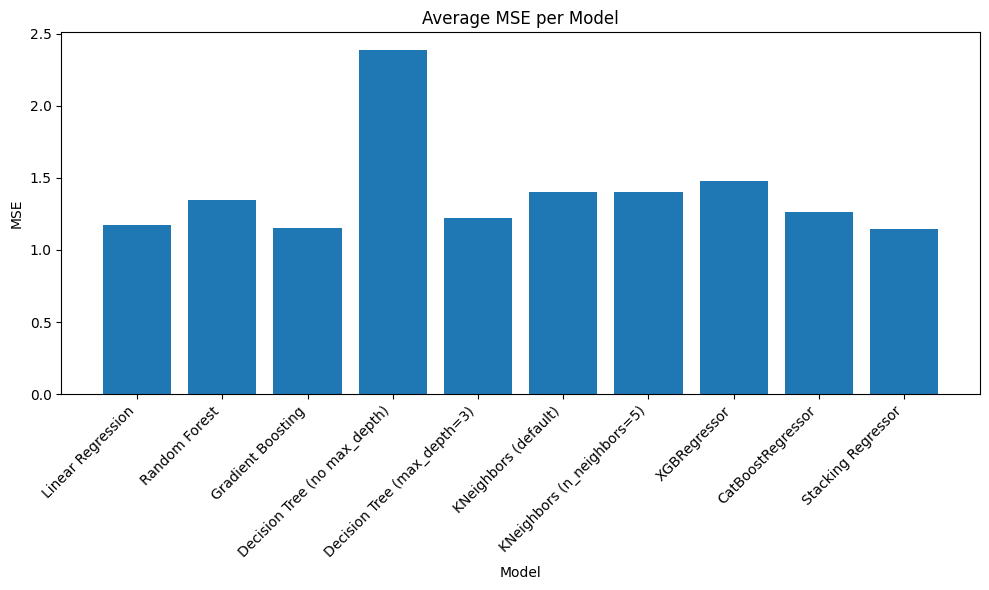

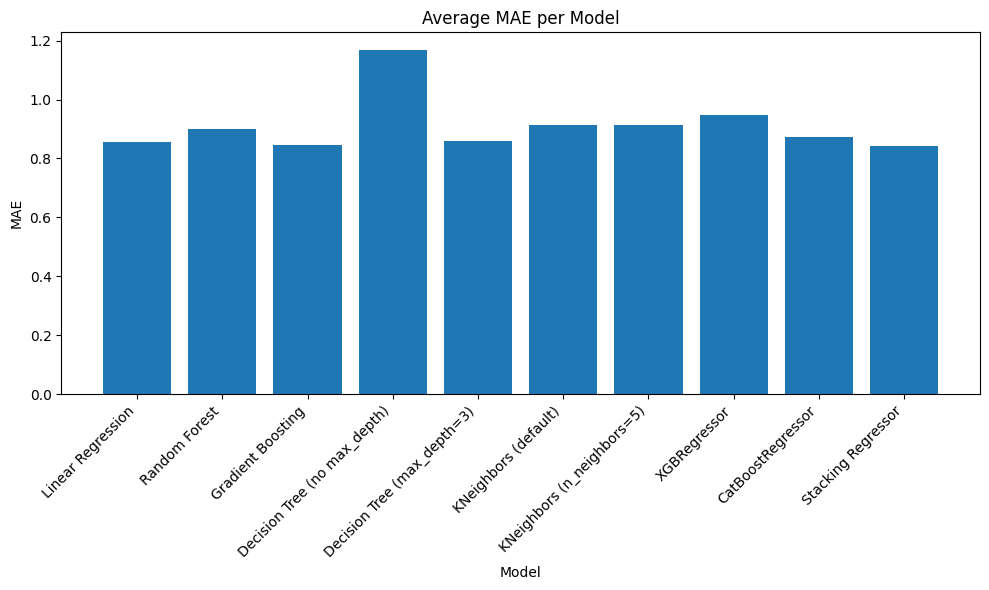

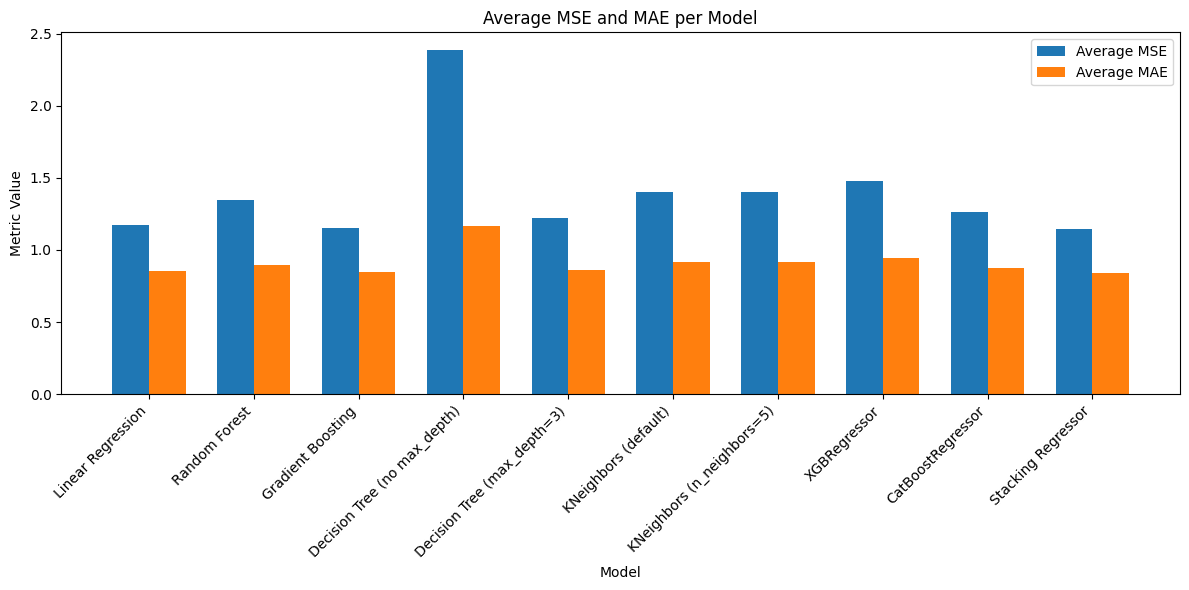

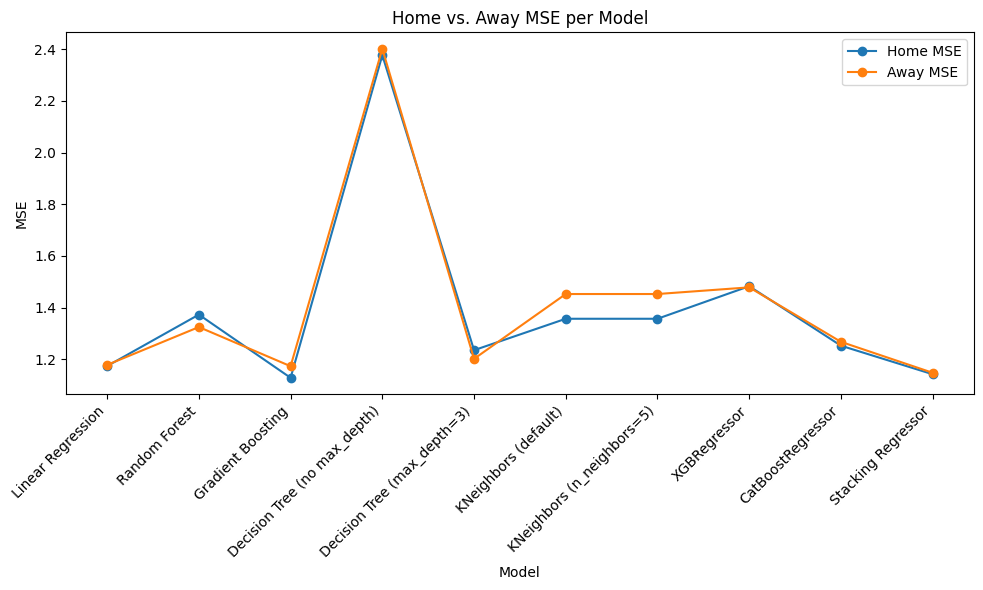

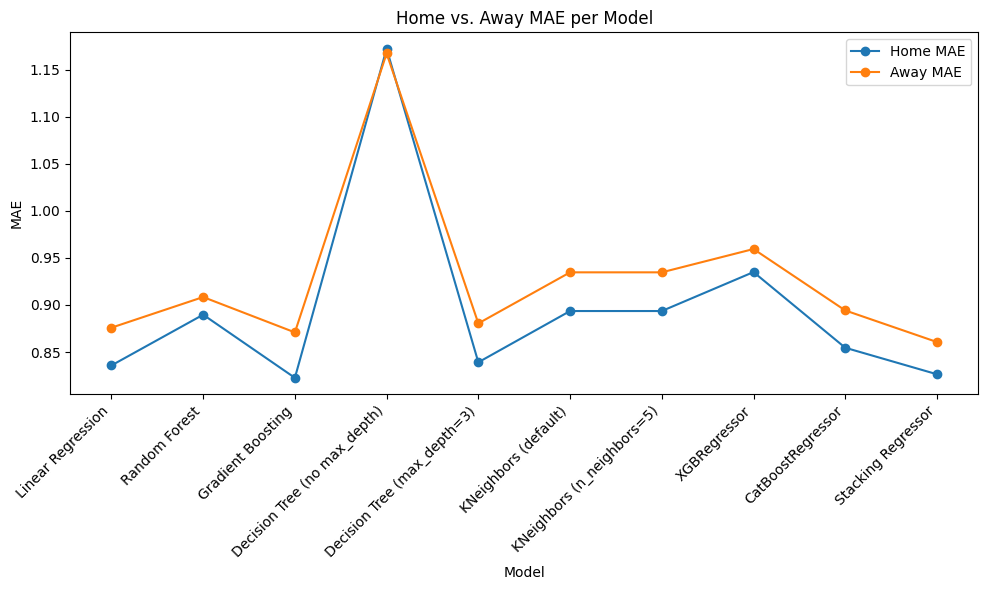

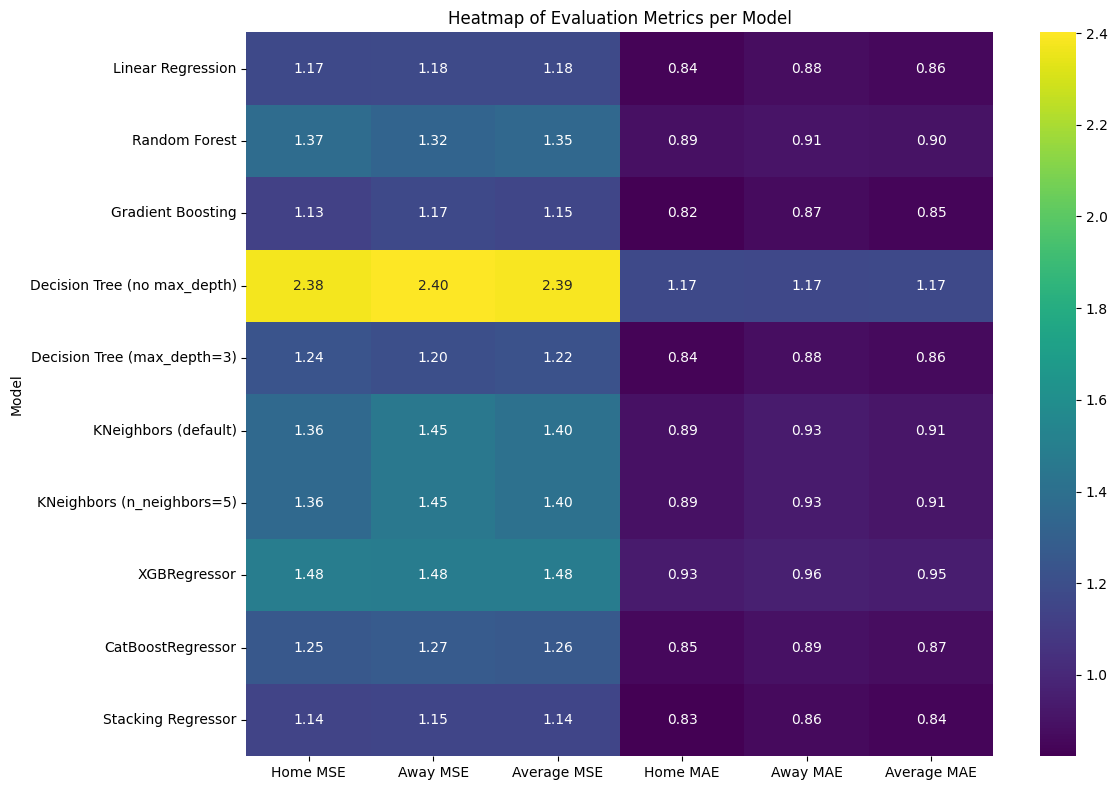

In [4]:
import seaborn as sns

# Function to plot MSE and MAE side by side
def plot_mse_mae_side_by_side(results):
    plt.figure(figsize=(12, 6))
    x = results["Model"]
    mse = results["Average MSE"]
    mae = results["Average MAE"]
    bar_width = 0.35
    index = np.arange(len(x))

    plt.bar(index, mse, bar_width, label="Average MSE")
    plt.bar(index + bar_width, mae, bar_width, label="Average MAE")

    plt.title("Average MSE and MAE per Model")
    plt.xlabel("Model")
    plt.ylabel("Metric Value")
    plt.xticks(index + bar_width / 2, x, rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to plot home vs. away metrics
def plot_home_away_metrics(results, metric):
    plt.figure(figsize=(10, 6))
    x = results["Model"]
    home = results[f"Home {metric}"]
    away = results[f"Away {metric}"]

    plt.plot(x, home, marker="o", label=f"Home {metric}")
    plt.plot(x, away, marker="o", label=f"Away {metric}")

    plt.title(f"Home vs. Away {metric} per Model")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to plot heatmap of metrics
def plot_metrics_heatmap(results):
    metrics = results.set_index("Model")[[
        "Home MSE", "Away MSE", "Average MSE",
        "Home MAE", "Away MAE", "Average MAE"
    ]]
    plt.figure(figsize=(12, 8))
    sns.heatmap(metrics, annot=True, fmt=".2f", cmap="viridis", cbar=True)
    plt.title("Heatmap of Evaluation Metrics per Model")
    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Preprocess data
    (X_train, X_test, y_home_train, y_home_test), (_, _, y_away_train, y_away_test) = preprocess_data()

    # Evaluate models
    results = evaluate_models(X_train, X_test, y_home_train, y_home_test, y_away_train, y_away_test)

    # Plot results
    plot_results(results, "MSE")
    plot_results(results, "MAE")
    plot_mse_mae_side_by_side(results)
    plot_home_away_metrics(results, "MSE")
    plot_home_away_metrics(results, "MAE")
    plot_metrics_heatmap(results)

# Execute the main function
main()